# Ontario Tech University

# Machine Learning - CSCI-5770G

## Final Project
Winter 2021

## Group members: 
Hooria Hajiyan (100758474)<br>
Aref Abed jooy Divshali (100795022)

# Problem Description

Due to the current situation during the COVID-19 pandemic, face mask detection has seen significant progress in Image processing and Computer vision. As a response to the COVID-19 pandemic, wearing a mask in public settings is an effective way to keep the communities safe.

In this project, we considered a Face-Mask Detection problem to detect if people are wearing a mask or not.

# Importing libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils.video import VideoStream
from PIL import Image
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizer
import tensorflow.keras.losses as losses
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import platform
import torch
import imutils
import cv2

# Initialization

In [3]:
Learn_rate = 1e-2
Epochs = 30
Batch_size = 128
Validation_split = 0.2
Verbose = 2
Test_data_size = 0.3

# Dataset

The dataset is publicly available on Kaggle:
https://www.kaggle.com/shanmukh05/mask-detection

### Dataset contains 2388 images in 2 classes : "yes" , "no"
#### Class 'yes' contains images of different persons wearing mask.

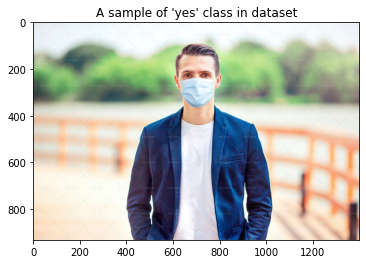

In [4]:
with_mask=Image.open(r"./mask_detection/yes/1.jpg")
with_mask_arr=np.array(with_mask)
plt.title("A sample of 'yes' class in dataset")
plt.imshow(with_mask_arr)

#### Class 'no' contains images of different persons not wearing mask.

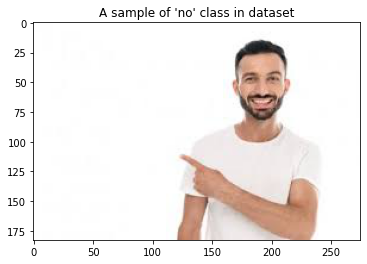

In [5]:
without_mask=Image.open(r"./mask_detection/no/1.jpg")
without_mask_arr=np.array(without_mask)
plt.title("A sample of 'no' class in dataset")
plt.imshow(without_mask_arr)

In [4]:
directory = r"mask_detection"
categories = ["no", "yes"] 

In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("loading images...")

data = []
labels = []

for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)
print("Images' size=" , data.shape)
print("Labels' size=", labels.shape)

loading images...
Images' size= (2388, 224, 224, 3)
Labels' size= (2388, 2)


#### Splitting the dataset into %70 train and %30 test data

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=Test_data_size,
                                                  stratify=labels,
                                                  random_state=14)

# Objective

The main purpose of this project is to develop a video-based mask detection system to distinguish whether a person is wearing a mask or not by getting input from the user's camera.  

# Methodology

To tackle this problem, we comapre 5 different models:

1- A Simple Convolutional Neural Network<br>
2- MobileNetV2<br>
3- ResNet50<br>
4- VGG16<br>
5- VGG19<br>

For each model, we trained the network using the training dataset. To avoid the overfitting problem, we applied cross-validation on 20 percent of data points in each epoch. The 'accuracy' and 'loss' metrics were captured during the training and the validation. The model was evaluated by test data.

To select the best model, all the results compared based on accuracy, loss, and execution time. Finally, the best model was used to apply face mask detection on a given input video from the user's camera using OpenCV.

## Record the execution time for each epoch

In [3]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

## Simple model

In [9]:
model_Simple = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="VALID", name='conv2d_1'),
    layers.MaxPooling2D(pool_size=(8, 8), name='maxpooling_1'),
    layers.Conv2D(filters=64, kernel_size=(12, 12), padding="VALID", name='conv2d_2'),
    layers.MaxPooling2D(pool_size=(2, 2), name='maxpooling_2'),
    layers.Conv2D(filters=128, kernel_size=(6, 6), padding="VALID", name='conv2d_3'),
    layers.MaxPooling2D(pool_size=(2, 2), name='maxpooling_3'),
    layers.Flatten(name="flatten"),
    layers.Dense(128, activation="relu", name="dense_relu_1"),
    layers.Dropout(0.2, name="dropout_1"),
    layers.Dense(64, activation="relu", name="dense_relu_2"),
    layers.Dropout(0.4, name="dropout_2"),
    layers.Dense(32, activation="relu", name="dense_relu_3"),
    layers.Dropout(0.4, name="dropout_3"),
    layers.Dense(2, activation="softmax", name="dense_softmax")
], name="Simple_Model")

model_Simple.compile(loss="binary_crossentropy", 
                     optimizer=optimizer.Adam(),
                     metrics=["accuracy"])

model_Simple.summary()

Model: "Simple_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
maxpooling_1 (MaxPooling2D)  (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        294976    
_________________________________________________________________
maxpooling_2 (MaxPooling2D)  (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)         295040    
_________________________________________________________________
maxpooling_3 (MaxPooling2D)  (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)              

In [10]:
print("Training Simple model...")
time_callback = TimeHistory()
Simple_log = model_Simple.fit(trainX, trainY, epochs=Epochs, batch_size=Batch_size,
                       validation_split = Validation_split, verbose=Verbose,
                             callbacks=[time_callback])
times_Simple = time_callback.times

Training Simple model...
Epoch 1/30
11/11 - 4s - loss: 0.7127 - accuracy: 0.5427 - val_loss: 0.6242 - val_accuracy: 0.6269
Epoch 2/30
11/11 - 1s - loss: 0.6459 - accuracy: 0.6482 - val_loss: 0.5525 - val_accuracy: 0.7582
Epoch 3/30
11/11 - 1s - loss: 0.5919 - accuracy: 0.7208 - val_loss: 0.5102 - val_accuracy: 0.7612
Epoch 4/30
11/11 - 1s - loss: 0.5678 - accuracy: 0.7470 - val_loss: 0.5044 - val_accuracy: 0.7343
Epoch 5/30
11/11 - 1s - loss: 0.5364 - accuracy: 0.7665 - val_loss: 0.5742 - val_accuracy: 0.7224
Epoch 6/30
11/11 - 1s - loss: 0.5322 - accuracy: 0.7522 - val_loss: 0.4735 - val_accuracy: 0.7761
Epoch 7/30
11/11 - 1s - loss: 0.5247 - accuracy: 0.7500 - val_loss: 0.4901 - val_accuracy: 0.7433
Epoch 8/30
11/11 - 1s - loss: 0.4779 - accuracy: 0.7874 - val_loss: 0.4666 - val_accuracy: 0.7940
Epoch 9/30
11/11 - 1s - loss: 0.4420 - accuracy: 0.8114 - val_loss: 0.4364 - val_accuracy: 0.7761
Epoch 10/30
11/11 - 1s - loss: 0.4274 - accuracy: 0.8114 - val_loss: 0.4375 - val_accuracy: 0

## Simple model Results

In [11]:
# make predictions on the testing set
print("Simple model - Make prediction on testing set...\n")
pred_Simple = model_Simple.predict(testX, batch_size=Batch_size)

# for each image in the testing set,
#we need to find the index of the label with corresponding largest predicted probability
predIndex_Simple = np.argmax(pred_Simple, axis=1)

# show the classification report
print(classification_report(testY.argmax(axis=1),
                            predIndex_Simple,
                            target_names=lb.classes_))

test_loss_Simple, test_acc_Simple = model_Simple.evaluate(testX, testY, verbose=Verbose)

Simple model - Make prediction on testing set...

              precision    recall  f1-score   support

          no       0.82      0.83      0.83       360
         yes       0.83      0.82      0.82       357

    accuracy                           0.83       717
   macro avg       0.83      0.83      0.83       717
weighted avg       0.83      0.83      0.83       717

23/23 - 0s - loss: 0.7187 - accuracy: 0.8257


Metrics = dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


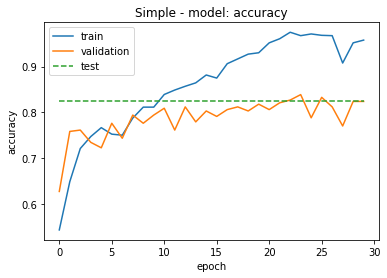

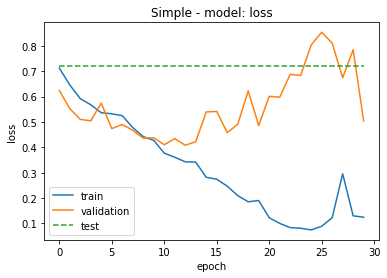

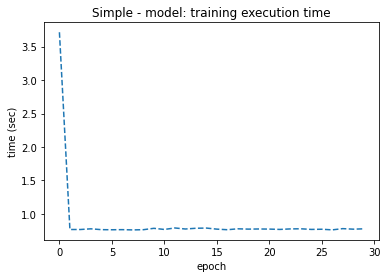

In [12]:
print("Metrics =", Simple_log.history.keys())
#  "Accuracy"
plt.plot(Simple_log.history['accuracy'])
plt.plot(Simple_log.history['val_accuracy'])
plt.plot([0, Epochs-1], [test_acc_Simple, test_acc_Simple], '--');
plt.title('Simple - model: accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc=0)
plt.show()
# "Loss"
plt.plot(Simple_log.history['loss'])
plt.plot(Simple_log.history['val_loss'])
plt.plot([0, Epochs-1], [test_loss_Simple, test_loss_Simple], '--');
plt.title('Simple - model: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc=0)
plt.show()
# "Execution Time"
plt.plot(np.arange(0,Epochs), np.array(times_Simple).reshape(Epochs,), '--');
plt.title('Simple - model: training execution time')
plt.ylabel('time (sec)')
plt.xlabel('epoch')
plt.show()

In [13]:
print("Total training execution time for Simple model:\n")
sum_times_Simple = np.sum(np.array(times_Simple))
print(sum_times_Simple)

Total training execution time for Simple model:

26.120580196380615


#### Save The Simple model

In [14]:
model_Simple.save('./models/Simple_Model.pb')
np.save('./params/Simple_params.npy',model_Simple.count_params())
np.save('./historys/Simple_history.npy',Simple_log.history)
np.save('./tests/test_acc_Simple.npy', test_acc_Simple)
np.save('./tests/test_loss_Simple.npy', test_loss_Simple)
np.save('./exec_times/sum_times_Simple.npy', sum_times_Simple)

INFO:tensorflow:Assets written to: ./models/Simple_Model.pb/assets


## MobileNetV2

#### Note:<br>
We trained the model using MobileNetV2 and MobileNetV3. Then we decided to continue with MobileNetV2 because it has a lower computational cost, and achieves high accuracy as well.

In [15]:
# Construct the head of the model that will be placed on top of the base model

# weights="imagenet" means using the pre-training on ImageNet
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=layers.Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.5)(headModel)
headModel = layers.Dense(2, activation="softmax")(headModel)

model_MobileNetV2 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False
    
model_MobileNetV2.compile(loss="binary_crossentropy", optimizer=optimizer.Adam(Learn_rate), metrics=["accuracy"])

model_MobileNetV2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [16]:
print("Training MobileNet...")
time_callback = TimeHistory()
MobileNet = model_MobileNetV2.fit(trainX, trainY, epochs=Epochs,
                                  batch_size=Batch_size, verbose=Verbose,
                                  validation_split = Validation_split,
                                  callbacks=[time_callback])

times_MobileNetV2 = time_callback.times

Training MobileNet...
Epoch 1/30
11/11 - 6s - loss: 0.5970 - accuracy: 0.8787 - val_loss: 0.1277 - val_accuracy: 0.9642
Epoch 2/30
11/11 - 2s - loss: 0.1219 - accuracy: 0.9611 - val_loss: 0.1296 - val_accuracy: 0.9493
Epoch 3/30
11/11 - 2s - loss: 0.0668 - accuracy: 0.9738 - val_loss: 0.0908 - val_accuracy: 0.9642
Epoch 4/30
11/11 - 2s - loss: 0.0550 - accuracy: 0.9798 - val_loss: 0.0966 - val_accuracy: 0.9701
Epoch 5/30
11/11 - 2s - loss: 0.0408 - accuracy: 0.9858 - val_loss: 0.0931 - val_accuracy: 0.9731
Epoch 6/30
11/11 - 2s - loss: 0.0301 - accuracy: 0.9910 - val_loss: 0.1010 - val_accuracy: 0.9701
Epoch 7/30
11/11 - 2s - loss: 0.0248 - accuracy: 0.9895 - val_loss: 0.0881 - val_accuracy: 0.9701
Epoch 8/30
11/11 - 2s - loss: 0.0311 - accuracy: 0.9895 - val_loss: 0.0915 - val_accuracy: 0.9672
Epoch 9/30
11/11 - 2s - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.1018 - val_accuracy: 0.9731
Epoch 10/30
11/11 - 2s - loss: 0.0141 - accuracy: 0.9970 - val_loss: 0.0936 - val_accuracy: 0.97

## MobileNetV2 Results

In [17]:
# make predictions on the testing set
print("MobileNetV2 model - Make prediction on testing set...\n")
pred_MobileNetV2 = model_MobileNetV2.predict(testX, batch_size=Batch_size)


# for each image in the testing set, 
# we need to find the index of the label with corresponding largest predicted probability.
predIndex_MobileNetV2 = np.argmax(pred_MobileNetV2, axis=1)

# show the classification report
print(classification_report(testY.argmax(axis=1),
                            predIndex_MobileNetV2,
                            target_names=lb.classes_))

test_loss_MobileNetV2, test_acc_MobileNetV2 = model_MobileNetV2.evaluate(testX, testY, verbose=Verbose)

MobileNetV2 model - Make prediction on testing set...

              precision    recall  f1-score   support

          no       0.94      0.99      0.96       360
         yes       0.99      0.94      0.96       357

    accuracy                           0.96       717
   macro avg       0.97      0.96      0.96       717
weighted avg       0.97      0.96      0.96       717

23/23 - 1s - loss: 0.1647 - accuracy: 0.9637


Metrics = dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


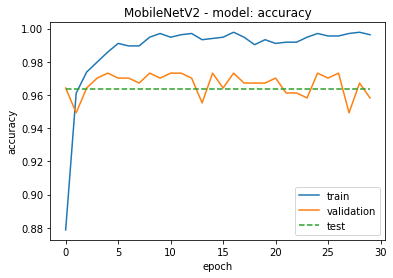

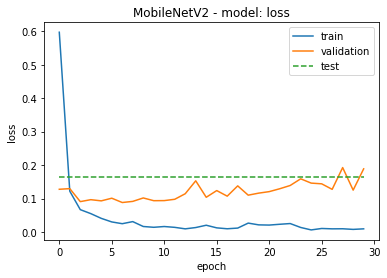

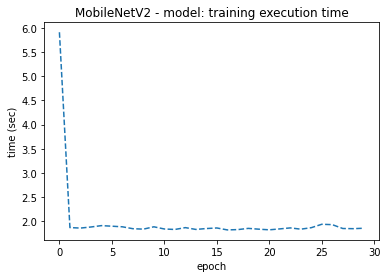

In [18]:
print("Metrics =", MobileNet.history.keys())
#  "Accuracy"
plt.plot(MobileNet.history['accuracy'])
plt.plot(MobileNet.history['val_accuracy'])
plt.plot([0, Epochs-1], [test_acc_MobileNetV2, test_acc_MobileNetV2], '--');
plt.title('MobileNetV2 - model: accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='lower right')
plt.show()
# "Loss"
plt.plot(MobileNet.history['loss'])
plt.plot(MobileNet.history['val_loss'])
plt.plot([0, Epochs-1], [test_loss_MobileNetV2, test_loss_MobileNetV2], '--');
plt.title('MobileNetV2 - model: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='upper right')
plt.show()
# "Execution Time"
plt.plot(np.arange(0,Epochs), np.array(times_MobileNetV2).reshape(Epochs,), '--');
plt.title('MobileNetV2 - model: training execution time')
plt.ylabel('time (sec)')
plt.xlabel('epoch')
plt.show()

In [19]:
print("Total training execution time for MobileNetV2 model:\n")
sum_times_MobileNetV2 = np.sum(np.array(times_MobileNetV2))
print(sum_times_MobileNetV2) 

Total training execution time for MobileNetV2 model:

59.931450605392456


#### Save The MobileNetV2 model

In [20]:
model_MobileNetV2.save('./models/MobileNetV2_Model.pb')
np.save('./params/MobileNetV2_params.npy',model_MobileNetV2.count_params())
np.save('./historys/MobileNetV2_history.npy',MobileNet.history)
np.save('./tests/test_acc_MobileNetV2.npy', test_acc_MobileNetV2)
np.save('./tests/test_loss_MobileNetV2.npy', test_loss_MobileNetV2)
np.save('./exec_times/sum_times_MobileNetV2.npy', sum_times_MobileNetV2)

INFO:tensorflow:Assets written to: ./models/MobileNetV2_Model.pb/assets


# ResNet50

In [21]:
# Construct the head of the model that will be placed on top of the base model

# weights="imagenet" means using the pre-training on ImageNet
baseModel = ResNet50(weights="imagenet", include_top=False,
                     input_tensor=layers.Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.5)(headModel)
headModel = layers.Dense(2, activation="softmax")(headModel)

model_ResNet50 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False
    
model_ResNet50.compile(loss="binary_crossentropy",
                       optimizer=optimizer.Adam(),
                       metrics=["accuracy"])

model_ResNet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [22]:
print("Training ResNet50...")
time_callback = TimeHistory()
ResNet = model_ResNet50.fit(trainX, trainY, epochs=Epochs,
                                  batch_size=Batch_size, verbose=Verbose,
                                  validation_split = Validation_split,
                                  callbacks=[time_callback])

times_ResNet50 = time_callback.times

Training ResNet50...
Epoch 1/30
11/11 - 10s - loss: 0.7744 - accuracy: 0.5195 - val_loss: 0.6839 - val_accuracy: 0.5403
Epoch 2/30
11/11 - 4s - loss: 0.6738 - accuracy: 0.5906 - val_loss: 0.6512 - val_accuracy: 0.6239
Epoch 3/30
11/11 - 4s - loss: 0.6549 - accuracy: 0.6085 - val_loss: 0.6447 - val_accuracy: 0.6507
Epoch 4/30
11/11 - 4s - loss: 0.6451 - accuracy: 0.6123 - val_loss: 0.6374 - val_accuracy: 0.6597
Epoch 5/30
11/11 - 4s - loss: 0.6427 - accuracy: 0.6235 - val_loss: 0.6351 - val_accuracy: 0.6507
Epoch 6/30
11/11 - 4s - loss: 0.6355 - accuracy: 0.6407 - val_loss: 0.6499 - val_accuracy: 0.5970
Epoch 7/30
11/11 - 4s - loss: 0.6358 - accuracy: 0.6257 - val_loss: 0.6342 - val_accuracy: 0.6627
Epoch 8/30
11/11 - 4s - loss: 0.6278 - accuracy: 0.6445 - val_loss: 0.6261 - val_accuracy: 0.6507
Epoch 9/30
11/11 - 4s - loss: 0.6208 - accuracy: 0.6534 - val_loss: 0.6268 - val_accuracy: 0.6687
Epoch 10/30
11/11 - 4s - loss: 0.6227 - accuracy: 0.6460 - val_loss: 0.6370 - val_accuracy: 0.62

## ResNet50 Results

In [23]:
# make predictions on the testing set
print("ResNet50 model - Make prediction on testing set...\n")
pred_ResNet50 = model_ResNet50.predict(testX, batch_size=Batch_size)


# for each image in the testing set, 
# we need to find the index of the label with corresponding largest predicted probability.
predIndex_ResNet50 = np.argmax(pred_ResNet50, axis=1)

# show the classification report
print(classification_report(testY.argmax(axis=1),
                            predIndex_ResNet50,
                            target_names=lb.classes_))

test_loss_ResNet50, test_acc_ResNet50 = model_ResNet50.evaluate(testX, testY, verbose=Verbose)

ResNet50 model - Make prediction on testing set...

              precision    recall  f1-score   support

          no       0.61      0.77      0.68       360
         yes       0.69      0.51      0.59       357

    accuracy                           0.64       717
   macro avg       0.65      0.64      0.63       717
weighted avg       0.65      0.64      0.63       717

23/23 - 2s - loss: 0.6185 - accuracy: 0.6402


Metrics = dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


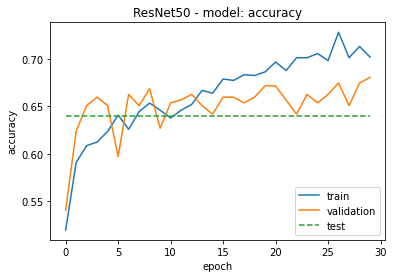

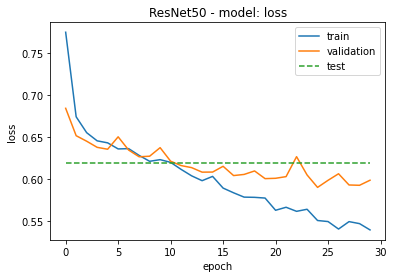

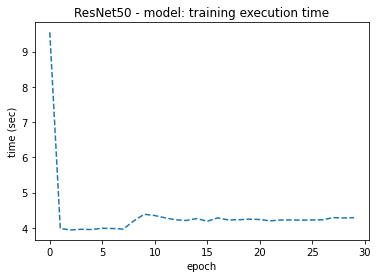

In [24]:
print("Metrics =", ResNet.history.keys())
#  "Accuracy"
plt.plot(ResNet.history['accuracy'])
plt.plot(ResNet.history['val_accuracy'])
plt.plot([0, Epochs-1], [test_acc_ResNet50, test_acc_ResNet50], '--');
plt.title('ResNet50 - model: accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='lower right')
plt.show()
# "Loss"
plt.plot(ResNet.history['loss'])
plt.plot(ResNet.history['val_loss'])
plt.plot([0, Epochs-1], [test_loss_ResNet50, test_loss_ResNet50], '--');
plt.title('ResNet50 - model: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='upper right')
plt.show()
# "Execution Time"
plt.plot(np.arange(0,Epochs), np.array(times_ResNet50).reshape(Epochs,), '--');
plt.title('ResNet50 - model: training execution time')
plt.ylabel('time (sec)')
plt.xlabel('epoch')
plt.show()

In [25]:
print("Total training execution time for ResNet50 model:\n")
sum_times_ResNet50 = np.sum(np.array(times_ResNet50))
print(sum_times_ResNet50)

Total training execution time for ResNet50 model:

130.766051530838


#### Save The ResNet50 model

In [26]:
model_ResNet50.save('./models/ResNet50_Model.pb')
np.save('./params/ResNet50_params.npy',model_ResNet50.count_params())
np.save('./historys/ResNet50_history.npy',ResNet.history)
np.save('./tests/test_acc_ResNet50.npy', test_acc_ResNet50)
np.save('./tests/test_loss_ResNet50.npy', test_loss_ResNet50)
np.save('./exec_times/sum_times_ResNet50.npy', sum_times_ResNet50)

INFO:tensorflow:Assets written to: ./models/ResNet50_Model.pb/assets


# VGG16

In [7]:
# Construct the head of the model that will be placed on top of the base model

# weights="imagenet" means using the pre-training on ImageNet
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.5)(headModel)
headModel = layers.Dense(2, activation="softmax")(headModel)

model_VGG16 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False
    
model_VGG16.compile(loss="binary_crossentropy",
                    optimizer=optimizer.Adam(),
                    metrics=["accuracy"])

model_VGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
print("Training VGG16...")
time_callback = TimeHistory()
VGG16 = model_VGG16.fit(trainX, trainY, epochs=Epochs,
                        batch_size=Batch_size, verbose=Verbose,
                        validation_split = Validation_split,
                        callbacks=[time_callback])

times_VGG16 = time_callback.times

Training VGG16...
Epoch 1/30
11/11 - 30s - loss: 0.6994 - accuracy: 0.5704 - val_loss: 0.5913 - val_accuracy: 0.8687
Epoch 2/30
11/11 - 5s - loss: 0.5800 - accuracy: 0.7567 - val_loss: 0.5044 - val_accuracy: 0.8687
Epoch 3/30
11/11 - 5s - loss: 0.4966 - accuracy: 0.8361 - val_loss: 0.4266 - val_accuracy: 0.8896
Epoch 4/30
11/11 - 5s - loss: 0.4329 - accuracy: 0.8540 - val_loss: 0.3671 - val_accuracy: 0.8866
Epoch 5/30
11/11 - 5s - loss: 0.3851 - accuracy: 0.8653 - val_loss: 0.3154 - val_accuracy: 0.9104
Epoch 6/30
11/11 - 5s - loss: 0.3463 - accuracy: 0.8847 - val_loss: 0.2818 - val_accuracy: 0.9224
Epoch 7/30
11/11 - 5s - loss: 0.3070 - accuracy: 0.8960 - val_loss: 0.2528 - val_accuracy: 0.9284
Epoch 8/30
11/11 - 5s - loss: 0.2851 - accuracy: 0.9019 - val_loss: 0.2298 - val_accuracy: 0.9343
Epoch 9/30
11/11 - 5s - loss: 0.2689 - accuracy: 0.9049 - val_loss: 0.2342 - val_accuracy: 0.9134
Epoch 10/30
11/11 - 5s - loss: 0.2514 - accuracy: 0.9087 - val_loss: 0.2018 - val_accuracy: 0.9313


## VGG16 Results

In [9]:
# make predictions on the testing set
print("VGG16 model - Make prediction on testing set...\n")
pred_VGG16 = model_VGG16.predict(testX, batch_size=Batch_size)


# for each image in the testing set, 
# we need to find the index of the label with corresponding largest predicted probability.
predIndex_VGG16 = np.argmax(pred_VGG16, axis=1)

# show the classification report
print(classification_report(testY.argmax(axis=1),
                            predIndex_VGG16,
                            target_names=lb.classes_))

test_loss_VGG16, test_acc_VGG16 = model_VGG16.evaluate(testX, testY, verbose=Verbose)

VGG16 model - Make prediction on testing set...

              precision    recall  f1-score   support

          no       0.97      0.96      0.96       360
         yes       0.96      0.97      0.96       357

    accuracy                           0.96       717
   macro avg       0.96      0.96      0.96       717
weighted avg       0.96      0.96      0.96       717

23/23 - 9s - loss: 0.1219 - accuracy: 0.9609


Metrics = dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


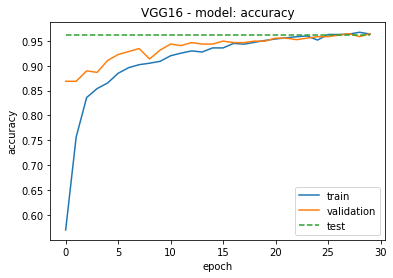

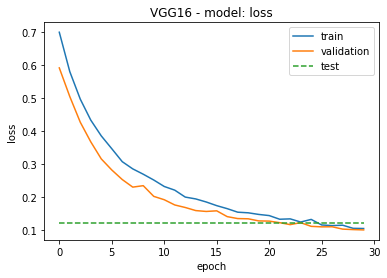

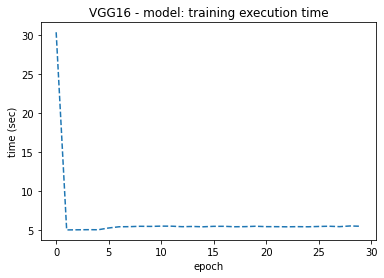

In [10]:
print("Metrics =", VGG16.history.keys())
#  "Accuracy"
plt.plot(VGG16.history['accuracy'])
plt.plot(VGG16.history['val_accuracy'])
plt.plot([0, Epochs-1], [test_acc_VGG16, test_acc_VGG16], '--');
plt.title('VGG16 - model: accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='lower right')
plt.show()
# "Loss"
plt.plot(VGG16.history['loss'])
plt.plot(VGG16.history['val_loss'])
plt.plot([0, Epochs-1], [test_loss_VGG16, test_loss_VGG16], '--');
plt.title('VGG16 - model: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='upper right')
plt.show()
# "Execution Time"
plt.plot(np.arange(0,Epochs), np.array(times_VGG16).reshape(Epochs,), '--');
plt.title('VGG16 - model: training execution time')
plt.ylabel('time (sec)')
plt.xlabel('epoch')
plt.show()

In [11]:
print("Total training execution time for VGG16 model:\n")
sum_times_VGG16 = np.sum(np.array(times_VGG16))
print(sum_times_VGG16)

Total training execution time for VGG16 model:

185.43850111961365


#### Save The VGG16 model

In [12]:
model_VGG16.save('./models/VGG16_Model.pb')
np.save('./params/VGG16_params.npy',model_VGG16.count_params())
np.save('./historys/VGG16_history.npy',VGG16.history)
np.save('./tests/test_acc_VGG16.npy', test_acc_VGG16)
np.save('./tests/test_loss_VGG16.npy', test_loss_VGG16)
np.save('./exec_times/sum_times_VGG16.npy', sum_times_VGG16)

INFO:tensorflow:Assets written to: ./models/VGG16_Model.pb/assets


# VGG19

In [7]:
# Construct the head of the model that will be placed on top of the base model

# weights="imagenet" means using the pre-training on ImageNet
baseModel = VGG19(weights="imagenet", include_top=False,
                  input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.5)(headModel)
headModel = layers.Dense(2, activation="softmax")(headModel)

model_VGG19 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False
    
model_VGG19.compile(loss="binary_crossentropy",
                    optimizer=optimizer.Adam(),
                    metrics=["accuracy"])

model_VGG19.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
print("Training VGG19...")
time_callback = TimeHistory()
VGG19 = model_VGG19.fit(trainX, trainY, epochs=Epochs,
                        batch_size=Batch_size, verbose=Verbose,
                        validation_split = Validation_split,
                        callbacks=[time_callback])

times_VGG19 = time_callback.times

Training VGG19...
Epoch 1/30
11/11 - 32s - loss: 0.7098 - accuracy: 0.5629 - val_loss: 0.5956 - val_accuracy: 0.8716
Epoch 2/30
11/11 - 6s - loss: 0.5909 - accuracy: 0.7493 - val_loss: 0.5002 - val_accuracy: 0.8746
Epoch 3/30
11/11 - 6s - loss: 0.5131 - accuracy: 0.8136 - val_loss: 0.4299 - val_accuracy: 0.8896
Epoch 4/30
11/11 - 6s - loss: 0.4426 - accuracy: 0.8496 - val_loss: 0.3705 - val_accuracy: 0.8925
Epoch 5/30
11/11 - 7s - loss: 0.3899 - accuracy: 0.8615 - val_loss: 0.3318 - val_accuracy: 0.8925
Epoch 6/30
11/11 - 7s - loss: 0.3629 - accuracy: 0.8645 - val_loss: 0.2802 - val_accuracy: 0.9313
Epoch 7/30
11/11 - 7s - loss: 0.3257 - accuracy: 0.8855 - val_loss: 0.2614 - val_accuracy: 0.9284
Epoch 8/30
11/11 - 6s - loss: 0.2893 - accuracy: 0.8990 - val_loss: 0.2381 - val_accuracy: 0.9254
Epoch 9/30
11/11 - 6s - loss: 0.2704 - accuracy: 0.9132 - val_loss: 0.2128 - val_accuracy: 0.9373
Epoch 10/30
11/11 - 6s - loss: 0.2396 - accuracy: 0.9266 - val_loss: 0.1954 - val_accuracy: 0.9343


## VGG19 Results

In [9]:
# make predictions on the testing set
print("VGG19 model - Make prediction on testing set...\n")
pred_VGG19 = model_VGG19.predict(testX, batch_size=Batch_size)


# for each image in the testing set, 
# we need to find the index of the label with corresponding largest predicted probability.
predIndex_VGG19 = np.argmax(pred_VGG19, axis=1)

# show the classification report
print(classification_report(testY.argmax(axis=1),
                            predIndex_VGG19,
                            target_names=lb.classes_))

test_loss_VGG19, test_acc_VGG19 = model_VGG19.evaluate(testX, testY, verbose=Verbose)

VGG19 model - Make prediction on testing set...

              precision    recall  f1-score   support

          no       0.96      0.95      0.95       360
         yes       0.95      0.96      0.95       357

    accuracy                           0.95       717
   macro avg       0.95      0.95      0.95       717
weighted avg       0.95      0.95      0.95       717

23/23 - 9s - loss: 0.1256 - accuracy: 0.9512


Metrics = dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


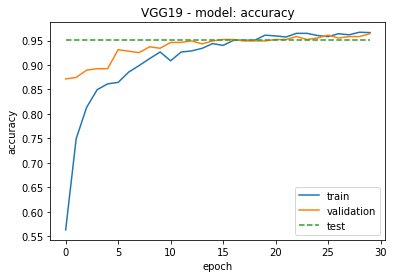

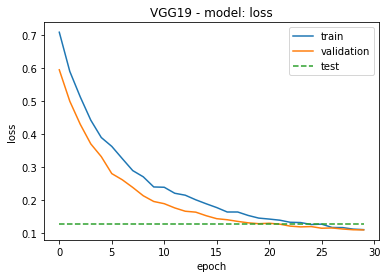

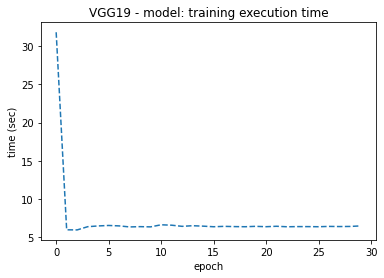

In [10]:
print("Metrics =", VGG19.history.keys())
#  "Accuracy"
plt.plot(VGG19.history['accuracy'])
plt.plot(VGG19.history['val_accuracy'])
plt.plot([0, Epochs-1], [test_acc_VGG19, test_acc_VGG19], '--');
plt.title('VGG19 - model: accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='lower right')
plt.show()
# "Loss"
plt.plot(VGG19.history['loss'])
plt.plot(VGG19.history['val_loss'])
plt.plot([0, Epochs-1], [test_loss_VGG19, test_loss_VGG19], '--');
plt.title('VGG19 - model: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='upper right')
plt.show()
# "Execution Time"
plt.plot(np.arange(0,Epochs), np.array(times_VGG19).reshape(Epochs,), '--');
plt.title('VGG19 - model: training execution time')
plt.ylabel('time (sec)')
plt.xlabel('epoch')
plt.show()

In [11]:
print("Total training execution time for VGG19 model:\n")
sum_times_VGG19 = np.sum(np.array(times_VGG19))
print(sum_times_VGG19)

Total training execution time for VGG19 model:

218.15954160690308


#### Save The VGG19 model

In [12]:
model_VGG19.save('./models/VGG19_Model.pb')
np.save('./params/VGG19_params.npy',model_VGG19.count_params())
np.save('./historys/VGG19_history.npy',VGG19.history)
np.save('./tests/test_acc_VGG19.npy', test_acc_VGG19)
np.save('./tests/test_loss_VGG19.npy', test_loss_VGG19)
np.save('./exec_times/sum_times_VGG19.npy', sum_times_VGG19)

INFO:tensorflow:Assets written to: ./models/VGG19_Model.pb/assets


# Experiments

#### Note: <br>
All the experiments were conducted using the following system:

In [45]:
print("="*20, "System Information", "="*20)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")
# Get the name of the current GPU
print("Name of the current GPU:",
      torch.cuda.get_device_name(torch.cuda.current_device()))
print("="*60)

==================== System Information ====================
System: Linux
Node Name: mcs03
Release: 4.4.0-193-generic
Version: #224-Ubuntu SMP Tue Oct 6 17:15:28 UTC 2020
Machine: x86_64
Processor: x86_64
Name of the current GPU: GeForce GTX TITAN X


## Load the models

In [16]:
# Simple model
loaded_Simple = np.load('./historys/Simple_history.npy',allow_pickle='TRUE').item()
loaded_count_params_Simple = np.load('./params/Simple_params.npy',allow_pickle='TRUE').item()
loaded_test_acc_Simple = np.load('./tests/test_acc_Simple.npy',allow_pickle='TRUE').item()
loaded_test_loss_Simple = np.load('./tests/test_loss_Simple.npy',allow_pickle='TRUE').item()
loaded_sum_times_Simple = np.load('./exec_times/sum_times_Simple.npy',allow_pickle='TRUE').item()


# MobileNetV2 model
loaded_MobileNetV2 = np.load('./historys/MobileNetV2_history.npy',allow_pickle='TRUE').item()
loaded_count_params_MobileNetV2 = np.load('./params/MobileNetV2_params.npy',allow_pickle='TRUE').item()
loaded_test_acc_MobileNetV2 = np.load('./tests/test_acc_MobileNetV2.npy',allow_pickle='TRUE').item()
loaded_test_loss_MobileNetV2 = np.load('./tests/test_loss_MobileNetV2.npy',allow_pickle='TRUE').item()
loaded_sum_times_MobileNetV2 = np.load('./exec_times/sum_times_MobileNetV2.npy',allow_pickle='TRUE').item()


# ResNet50 model
loaded_ResNet50 = np.load('./historys/ResNet50_history.npy',allow_pickle='TRUE').item()
loaded_count_params_ResNet50 = np.load('./params/ResNet50_params.npy',allow_pickle='TRUE').item()
loaded_test_acc_ResNet50 = np.load('./tests/test_acc_ResNet50.npy',allow_pickle='TRUE').item()
loaded_test_loss_ResNet50 = np.load('./tests/test_loss_ResNet50.npy',allow_pickle='TRUE').item()
loaded_sum_times_ResNet50 = np.load('./exec_times/sum_times_ResNet50.npy',allow_pickle='TRUE').item()


# VGG16 model
loaded_VGG16 = np.load('./historys/VGG16_history.npy',allow_pickle='TRUE').item()
loaded_count_params_VGG16 = np.load('./params/VGG16_params.npy',allow_pickle='TRUE').item()
loaded_test_acc_VGG16 = np.load('./tests/test_acc_VGG16.npy',allow_pickle='TRUE').item()
loaded_test_loss_VGG16 = np.load('./tests/test_loss_VGG16.npy',allow_pickle='TRUE').item()
loaded_sum_times_VGG16 = np.load('./exec_times/sum_times_VGG16.npy',allow_pickle='TRUE').item()


# VGG19 model
loaded_VGG19 = np.load('./historys/VGG19_history.npy',allow_pickle='TRUE').item()
loaded_count_params_VGG19 = np.load('./params/VGG19_params.npy',allow_pickle='TRUE').item()
loaded_test_acc_VGG19 = np.load('./tests/test_acc_VGG19.npy',allow_pickle='TRUE').item()
loaded_test_loss_VGG19 = np.load('./tests/test_loss_VGG19.npy',allow_pickle='TRUE').item()
loaded_sum_times_VGG19 = np.load('./exec_times/sum_times_VGG19.npy',allow_pickle='TRUE').item()

## Comparing the results

#### Note: <br>
To select the best model, all the results were compared based on accuracy, execution time, and number of parameters.

Text(0.5, 0, 'epoch')

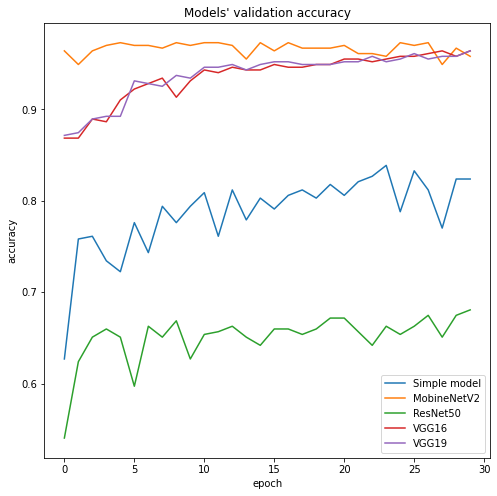

In [18]:
plt.figure(figsize=(8,8))
plt.plot(loaded_Simple['val_accuracy'])
plt.plot(loaded_MobileNetV2['val_accuracy'])
plt.plot(loaded_ResNet50['val_accuracy'])
plt.plot(loaded_VGG16['val_accuracy'])
plt.plot(loaded_VGG19['val_accuracy'])
plt.legend(["Simple model", "MobineNetV2", "ResNet50", "VGG16","VGG19"], loc='lower right')
plt.title('Models\' validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

#### Validation accuracy<br>
This figure shows the validation accuracy of the models during training. So, by using the MobileNetV2 model we expect to achieve high accuracy on the test dataset.

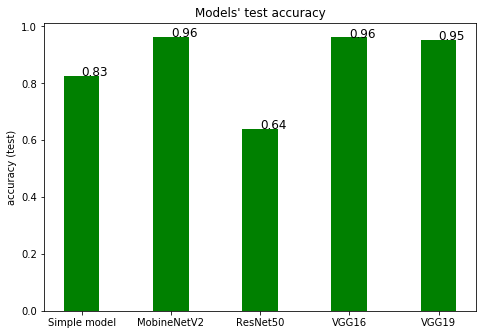

In [139]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models_name_list_accuracy = ["Simple model", "MobineNetV2","ResNet50", "VGG16","VGG19"]
test_acc_list = [loaded_test_acc_Simple,
            loaded_test_acc_MobileNetV2,
            loaded_test_acc_ResNet50,
            loaded_test_acc_VGG16,
            loaded_test_acc_VGG19]
ax.bar(models_name_list_accuracy,test_acc_list, width = [0.4], color='g')
plt.title('Models\' test accuracy')
plt.ylabel('accuracy (test)')
for index, value in enumerate(test_acc_list):
    value_format="{:.2f}".format(value)
    plt.text(index, value, str(value_format), fontsize=12, color='black')
plt.show()

#### Accuracy:<br>
As the figure shows, the MobileNetV2 model reaches the highest accuracy on the test data with 0.96 percent.

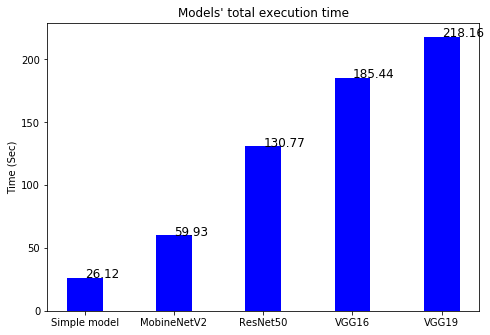

In [133]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models_name_list_time = ["Simple model", "MobineNetV2", "ResNet50", "VGG16","VGG19"]
sum_times_list = [loaded_sum_times_Simple,
            loaded_sum_times_MobileNetV2,
            loaded_sum_times_ResNet50,
            loaded_sum_times_VGG16,
            loaded_sum_times_VGG19]
ax.bar(models_name_list_time,sum_times_list, width = [0.4], color = 'b')
plt.title('Models\' total execution time')
plt.ylabel('Time (Sec)')
for index, value in enumerate(sum_times_list):
    value_format="{:.2f}".format(value)
    plt.text(index, value, str(value_format), fontsize=12, color='black')
plt.show()

#### Total execution time<br>
This plot shows the total execution time each model takes during the training. According to the high accuracy of the MobileNetV2 model, it just takes around 1 minute to train which is perfectly reasonable with respect to the size of the model and the given dataset.

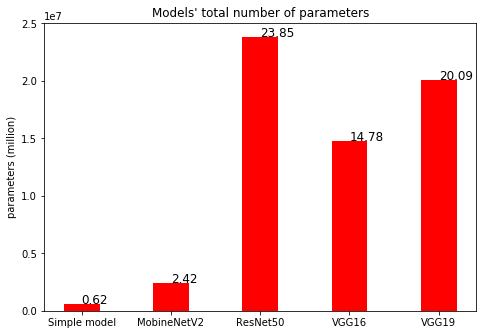

In [136]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models_name_list_param = ["Simple model", "MobineNetV2", "ResNet50", "VGG16","VGG19"]
count_params_list = [loaded_count_params_Simple,
            loaded_count_params_MobileNetV2,
            loaded_count_params_ResNet50,
            loaded_count_params_VGG16,
            loaded_count_params_VGG19]
ax.bar(models_name_list_param,count_params_list, width = [0.4], color='red')
plt.title('Models\' total number of parameters')
plt.ylabel('parameters (million)')
for index, value in enumerate(count_params_list):
    param_million = (value/10**6)
    value_format="{:.2f}".format(param_million)
    plt.text(index, value, str(value_format), fontsize=12, color='black')
plt.show()

#### Number of parameters<br>
The figure above compares the total number of parameters each model needs to tune during the training. According to this, we can contend the MobileNetV2 model is the best model with respect to the computational cost, accuracy and execution time.

# Use Selected Model

### MobileNetV2

This selected model is used as a face mask detector to apply mask detection task on each frame of the input video from user's camera. OpenCV library is used for face detection.

In [2]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

# load our serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk 
maskNet = load_model("./models/MobileNetV2_Model.pb")

# initialize the video stream
print("INFO: starting video stream...")
vs = VideoStream(src=0).start()

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (withoutMask, mask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

        
# do a bit of cleanup
vs.stop()
cv2.destroyAllWindows()

INFO: starting video stream...
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 20